# Convex treemap
Also called: Voronoi treemap, Polygonal partition

![alt text](https://datavizproject.com/wp-content/uploads/2015/10/DVP-37.png)


Similar to a regular square treemap, but convex polygons are used instead of rectangles e.g. a new hierarchical partition scheme, also called a polygonal partition, which uses convex polygons rather than just rectangles.

Treemaps display hierarchical (tree-structured) data as a set of nested polygons. Each branch of the tree is given a polygons, which is then tiled with smaller polygons representing sub-branches.

The use of Convex Treemaps compared to regular tree maps would be when you want to show grouping and realtions instead of the strict hierachical structure of a a normal treemap.

# Examples


Ref
https://ipython-books.github.io/145-computing-the-voronoi-diagram-of-a-set-of-points/

In [2]:
!pip install git+https://github.com/rossant/smopy.git

  Cloning https://github.com/rossant/smopy.git to /tmp/pip-req-build-bv89wv8p
  Running command git clone -q https://github.com/rossant/smopy.git /tmp/pip-req-build-bv89wv8p
  Created wheel for smopy: filename=smopy-0.0.7-cp37-none-any.whl size=6143 sha256=052145dff181d87265aef4e1a13cc3717307a05a31fd1e6aa3f5eb6bfb5eb5f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-qi8hqajd/wheels/82/61/5a/999025a8b645a08097bf28d55bc9133544618b33e6c458f894
Successfully built smopy


In [3]:
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import smopy
%matplotlib inline

In [6]:
!wget https://github.com/ipython-books/cookbook-2nd-data/blob/master/ratp.csv?raw=true

--2019-10-29 10:14:02--  https://github.com/ipython-books/cookbook-2nd-data/blob/master/ratp.csv?raw=true
Connecting to 168.219.61.252:8080... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://github.com/ipython-books/cookbook-2nd-data/raw/master/ratp.csv [following]
--2019-10-29 10:14:02--  https://github.com/ipython-books/cookbook-2nd-data/raw/master/ratp.csv
Reusing existing connection to github.com:443.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ipython-books/cookbook-2nd-data/master/ratp.csv [following]
--2019-10-29 10:14:02--  https://raw.githubusercontent.com/ipython-books/cookbook-2nd-data/master/ratp.csv
Connecting to 168.219.61.252:8080... connected.
Proxy request sent, awaiting response... 200 OK
Length: 896301 (875K) [text/plain]
Saving to: ‘ratp.csv?raw=true’

ratp.csv?raw=true   100%[===================>] 875.29K  1.50MB/s    in 0.6s    

2019-10-29 10:14:04 (1.50 MB/s) - ‘ratp.csv?raw=true’

In [7]:
df = pd.read_csv('ratp.csv',
                 sep='#', header=None)
df[df.columns[1:]].tail(3)

1          2                       3              4     5
11608  2.350173  48.937238  THEATRE GERARD PHILIPE    SAINT-DENIS  tram
11609  2.301197  48.933118                 TIMBAUD  GENNEVILLIERS  tram
11610  2.230144  48.913708            VICTOR BASCH       COLOMBES  tram

In [8]:
metro = df[(df[5] == 'metro')]
metro[metro.columns[1:]].tail(3)

1          2                     3            4      5
305  2.308041  48.841697           Volontaires  PARIS-15EME  metro
306  2.379884  48.857876  Voltaire (Léon Blum)  PARIS-11EME  metro
307  2.304651  48.883874                Wagram  PARIS-17EME  metro

In [9]:
# We only extract the district from stations in Paris.
paris = metro[4].str.startswith('PARIS').values
# We create a vector of integers with the district
# number of the corresponding station, or 0 if the
# station is not in Paris.
districts = np.zeros(len(paris), dtype=np.int32)
districts[paris] = metro[4][paris].str.slice(6, 8) \
    .astype(np.int32)
districts[~paris] = 0
ndistricts = districts.max() + 1

In [10]:
lon = metro[1]
lat = metro[2]

In [11]:
box = (lat[paris].min(), lon[paris].min(),
       lat[paris].max(), lon[paris].max())
m = smopy.Map(box, z=12)
m.show_ipython()

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)>

In [12]:
vor = spatial.Voronoi(np.c_[lat, lon])

In [13]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [14]:
regions, vertices = voronoi_finite_polygons_2d(vor)
cells = [m.to_pixels(vertices[region])
         for region in regions]

NameError: name 'm' is not defined

In [15]:
cmap = plt.cm.Set3
# We generate colors for districts using a color map.
colors_districts = cmap(
    np.linspace(0., 1., ndistricts))[:, :3]
# The color of every polygon, grey by default.
colors = .25 * np.ones((len(districts), 3))
# We give each polygon in Paris the color of
# its district.
colors[paris] = colors_districts[districts[paris]]

In [16]:
ax = m.show_mpl(figsize=(12, 8))
ax.add_collection(
    mpl.collections.PolyCollection(
        cells, facecolors=colors,
        edgecolors='k', alpha=.35))

NameError: name 'm' is not defined

## Scipy.spatial.Voronoi

In [18]:
import numpy as np
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                    [2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

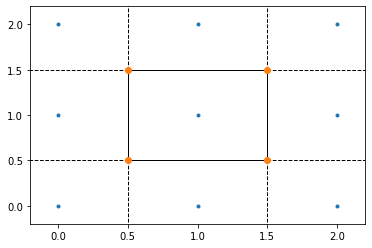

In [19]:
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()

In [20]:
vor.vertices

array([[0.5, 0.5],
       [1.5, 0.5],
       [0.5, 1.5],
       [1.5, 1.5]])

In [21]:
vor.regions

[[],
 [-1, 0],
 [-1, 1],
 [1, -1, 0],
 [3, -1, 2],
 [-1, 3],
 [-1, 2],
 [3, 2, 0, 1],
 [2, -1, 0],
 [3, -1, 1]]

In [22]:
vor.ridge_points

array([[0, 1],
       [0, 3],
       [6, 3],
       [6, 7],
       [3, 4],
       [5, 8],
       [5, 2],
       [5, 4],
       [8, 7],
       [2, 1],
       [4, 1],
       [4, 7]], dtype=int32)

## Plotly
https://plot.ly/~empet/14000.embed

In [23]:
import scipy
scipy. __version__

'1.3.1'

In [24]:
from scipy.spatial import SphericalVoronoi
from scipy.interpolate import splev,  splprep
import numpy as np

In [25]:
import plotly.offline as py
from plotly.graph_objs import *

In [26]:
def sphere():
    theta=np.linspace(0, 2*np.pi, 200)
    phi=np.linspace(0, np.pi, 100)
    theta, phi=np.meshgrid(theta, phi)
    x=np.cos(theta)*np.sin(phi)
    y=np.sin(theta)*np.sin(phi)
    z=np.cos(phi)
    return x, y ,z

In [27]:
def s_Voronoi(points):
    if not isinstance(points, np.ndarray):
        raise ValueError('points must be a numpy array of shape (n,3)')
        
    center = np.zeros(3)
    radius = 1.0
    sv = SphericalVoronoi(points, radius, center)
    sv.sort_vertices_of_regions()# sort vertices
    return sv

In [28]:
def points_sphere(N=80):
    points=np.random.randn(N,3)
    return points/np.linalg.norm(points, axis=1)[:, None]

In [29]:
def spheric_arcs(sv, R=1.005):
    
    #sv is an instance of SphericalVoronoi class
    #R is a radius slightly greater than 1; the arcs are plotted on the shere of radius R
    #to avoid to be covered by the sphere surface
    
    t=np.array([0, 0.25, 0.5, 0.75, 1.0])# five parameters for convex combination of points
    p=(1-t)[:, None]
    q=t[:, None]
    #Xa, Ya, Za  are the lists of point coordinates to be plotted as spherical arcs
    Xa=[]
    Ya=[]
    Za=[]
    for region in sv.regions:
        P=sv.vertices[region]#P is an array whose rows are the vertices of the Voronoi points on the sphere
        L=P.shape[0]
        for k in range(L):
            B=np.array([P[k,:]]*5)
            C=np.array([P[(k+1)%L, :]]*5)
            A=B*p+C*q#A is an array of 5 points on the segment of ends P[k,:], P[(k+1)%L, :]
       
            A=R*A/np.linalg.norm(A, axis=1)[:, None]#central projection of the points in A onto the sphere 
            tck,u=splprep([A[:,0],A[:,1],A[:,2]],s=0)
            xi,yi, zi= splev(np.linspace(0,1,20),tck)#spline interpolation of the five points on sphere
            Xa+=xi.tolist()
            Ya+=yi.tolist()
            Za+=zi.tolist()
        Xa+=[None]  #after processing a region insert None in each list to avoid 
        Ya+=[None]  #unwanted lines from one region to another
        Za+=[None]
    
    return Xa, Ya, Za

In [30]:
def polygons(sv):
    Xp=[]
    Yp=[]
    Zp=[]

    for region in sv.regions:
        V=sv.vertices[region]
        Xp+=V[:,0].tolist()+[V[0,0], None]
        Yp+=V[:,1].tolist()+[V[0,1], None]
        Zp+=V[:,2].tolist()+[V[0,2], None]
    return Xp, Yp, Zp    

In [43]:
def triangulate_regions(sv, colors):

    simplices=[]# a list of 3-lists of integers giving the vertex indices of a triangle
    facecolor=[]# the list of colors associated to each simplex in the triangulation
   
    for k, region  in enumerate(sv.regions):
        color=colors[np.random.randint(0, len(colors))]# choose the color for the region region
        #triangulate the region 
        simplices+=[[region[0], region[j], region[j+1]] for j in range(1, len(region)-1)]
        facecolor+=[color for _  in range(1, len(region)-1)]
    return simplices, facecolor

In [31]:
def polygons(sv):
    Xp=[]
    Yp=[]
    Zp=[]

    for region in sv.regions:
        V=sv.vertices[region]
        Xp+=V[:,0].tolist()+[V[0,0], None]
        Yp+=V[:,1].tolist()+[V[0,1], None]
        Zp+=V[:,2].tolist()+[V[0,2], None]
    return Xp, Yp, Zp    

In [32]:
def get_data(points,  R=1.005, arcs=True, colorscale=[], colors=[]):
    
    #for arcs=True, and colorscale of length at least 2, the function set up data for plotting the sphere, data points and
    #spherical arcs 
    # for arcs=False, and length of colors,  non zero -> data for the polyhedral approximation: points, sides of polygons, 
    # colored planar Voronoi regions
    
    sv=s_Voronoi(points)
    
    if arcs:
        if  len(colorscale)<2:
            raise ValueError('the colorscale must have at least length=2')
        x, y, z=sphere()
        sphere_surf=Surface(x=x, y=y, z=z, colorscale=colorscale, showscale=False, name='sphere')
        data_pts=Scatter3d(x=R*points[:,0], y=R*points[:,1], z=R*points[:,2], name='points',
                   mode='markers', marker=dict(color='black', size=3))
        Xa, Ya, Za=spheric_arcs(sv,R=R)
        lines=Scatter3d(x=Xa, y=Ya, z=Za,  name='spheric arc',  mode='lines',
                line=dict(width=2, color='rgb(10,10,10)')) 
        
        return Data([sphere_surf, data_pts, lines ])
    else:
        if len(colors)==0:
            raise ValueError('the list of colors is empty')
        simplices, facecolor=triangulate_regions(sv, colors=colors)    
        I, J, K=np.array(simplices).T
        x,y,z=sv.vertices.T
        triangles=Mesh3d(x=x,
                     y=y,
                     z=z,
                     facecolor=facecolor, 
                     i=I,
                     j=J,
                     k=K,
                     name='',
                    )
        data_pts=Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], name='points',
                   mode='markers', marker=dict(color='black', size=2))
        Xp, Yp, Zp=polygons(sv)
        lines=Scatter3d(x=Xp, y=Yp, z=Zp,  name='spheric arc',  mode='lines',
                line=dict(width=2, color='rgb(10,10,10)')) 
        
        return Data([triangles, data_pts, lines])

In [33]:
axis = dict(
            showbackground=True, 
            backgroundcolor='rgb(40,40,40)', #"rgb(230, 230,230)",
            gridcolor='rgb(255, 255, 255)',      
            zerolinecolor='rgb(255, 255, 255)',  
            )
noaxis=dict(showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            ticks='',
            title='',
            zeroline=False)

In [34]:
def plot_layout(ax=noaxis):

    return Layout(title='Spherical Voronoi Diagram',
                  font=dict(family='Balto', size=16),
                  width=700,
                  height=700,
                  showlegend=False,
                  scene=Scene(xaxis=XAxis(ax),
                              yaxis=YAxis(ax), 
                              zaxis=ZAxis(ax), 
                              aspectratio=dict(x=1,
                                               y=1,
                                               z=1
                                              ),
                                )
                    )
  

In [35]:
points=points_sphere(N=80)

In [36]:
pl_col=[[0.0, 'rgb(230,230,230)'], [1.0, 'rgb(230,230,230)']]

In [37]:
data1=get_data(points,  R=1.005, arcs=True, colorscale=pl_col, colors=[])

/home/sean/anaconda3/envs/gpi/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




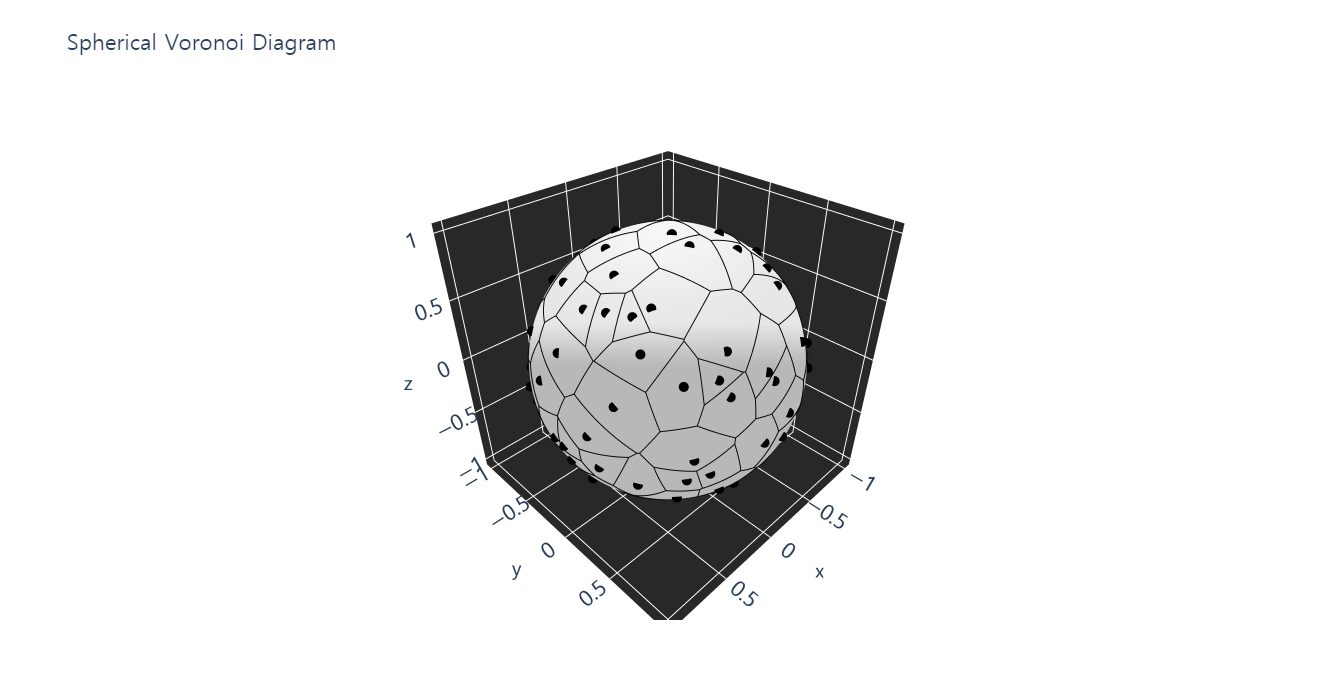

In [39]:
fig1 = Figure(data=data1, layout=plot_layout(ax=axis))
#py.sign_in('empet', 'jhog40sb94')
py.iplot(fig1, filename='sph-voronoi-axes')

In [40]:
colors=['rgb(53,195,176)',
'rgb(168,201,121)',
'rgb(255,210,181)',
'rgb(255,169,164)',
'rgb(255,140,148)']

In [44]:
points=points_sphere(N=100)
data2=get_data(points,  R=1.005, arcs=False, colorscale=[], colors=colors)

In [ ]:
fig2 = Figure(data=data2, layout=plot_layout(ax=noaxis))
fig2['layout'].update(title='Polyhedral approximation of a spherical Voronoi diagram')
py.iplot(fig2, filename='polyhedral-voronoi')